# Implementação com base de dados adquirida em aula

- Carregar dataset
- Aplicar filtros temporais
- Realizar segmentações (tempo | frequência)
- Criar vetores de características: VAR, RMS, ... (tempo) e FMD, FMN, ... (frequência)
- Aplicar 1 método de seleção de característica (p.e Select Kbest)
- Classificação (SVM)

# Carregamento da base de dados

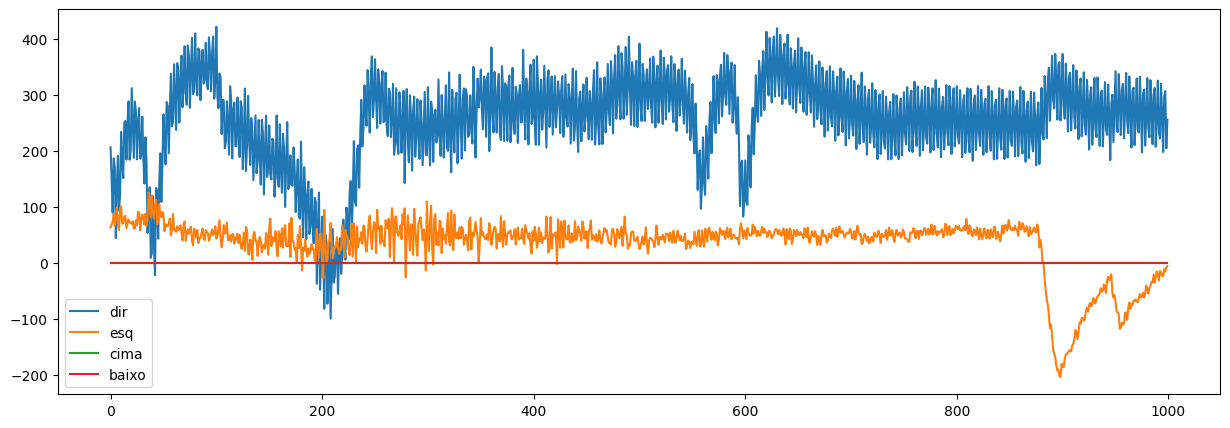

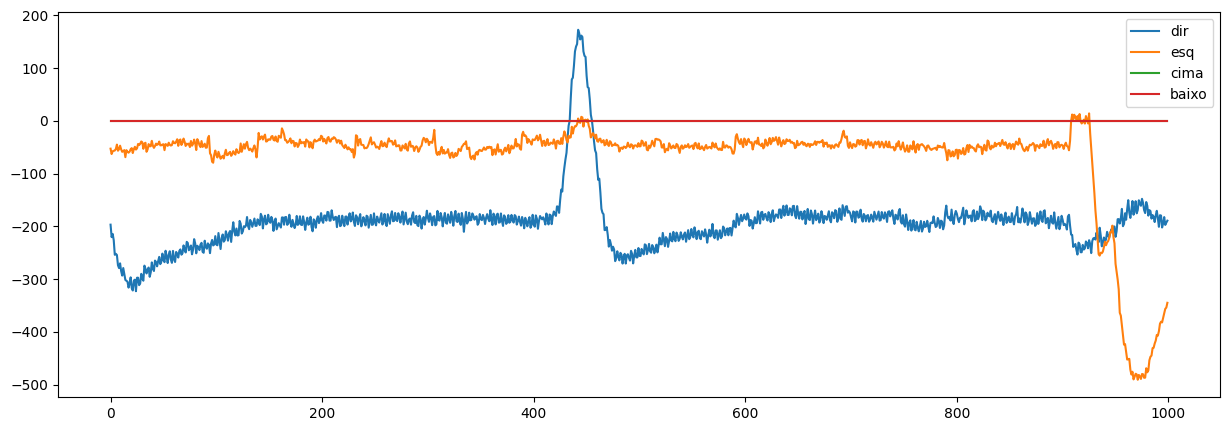

In [278]:
from scipy import signal
import numpy as np


labels_str = ['dir', 'esq', 'cima', 'baixo', 'cima', 'baixo',
              'baixo', 'esq', 'dir', 'baixo', 'dir', 'dir', 'esq', 'cima',
              'baixo', 'cima', 'esq', 'dir', 'cima', 'esq', 'baixo', 'esq',
              'dir', 'esq', 'cima', 'dir', 'cima', 'baixo']


dataGabi = np.load("datasets/Gabi.npy")
dataJesse = np.load("datasets/Jesse.npy")

# Entendimento dos dados
dataGabi.shape, dataJesse.shape
# ((28, 1000, 4), (28, 1000, 4))

# Sempre tem 4 dados(4 eletrodos), os dois primeiros tem dados e os dois dps nao tem nada
# print(dataGabi)
# 4 -> eletrodo, canais, mas so estamos utilizando 2
    # Usando so 2 porque estamos fazendo uma diferença de potencial
# 28 -> classes, movimentos, comandos, amostras
# 1000 -> quantidade de pontos, 5segundos * 200hz


##vizualização dos dados
import matplotlib.pyplot as plt

for i in range(4):
    plt.plot(dataGabi[0, :, i])
plt.legend(labels_str)
plt.show()

for i in range(4):
    plt.plot(dataJesse[0, :, i])
plt.legend(labels_str)
plt.show()



In [279]:
# Correção do numero de eletrodos e unificação

# os dois primeiros eletrodos sao funcionais
dataGabi = dataGabi[:,:,:2]
dataJesse = dataJesse[:,:,:2]

# Entendimento dos dados
dataGabi.shape, dataJesse.shape
# ((28, 1000, 2), (28, 1000, 2))

data = np.array([dataGabi, dataJesse])
# data.shape
# (2, 28, 1000, 2)

# Esse transpose é so pra fazer o 1000 ir pra quarta posição
    # Para os dados que foram capturados sempre precisam ficar na posição final
    # O padrao de todas as funções do numpy scipy e tal é sempre em cima do axis -1 (ultima dimensao)
    # Padronização apeans
# Colocando os dados na dimensao final
data = data.transpose(0,1,3,2)
data.shape
# (2, 28, 2, 1000)

(2, 28, 2, 1000)

In [280]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
# import numpy as np
# from scipy import signal
# from sklearn.preprocessing import LabelEncoder
# import mne

# Funções para aplicação dos filtros temporais
def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

FS = 200

def print_graphs(data):
    for i in range(data.shape[0]):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()


# Aplicação dos filtros

Grafico do sujeito {i} depois do filtro
Grafico do sujeito {i} depois do filtro


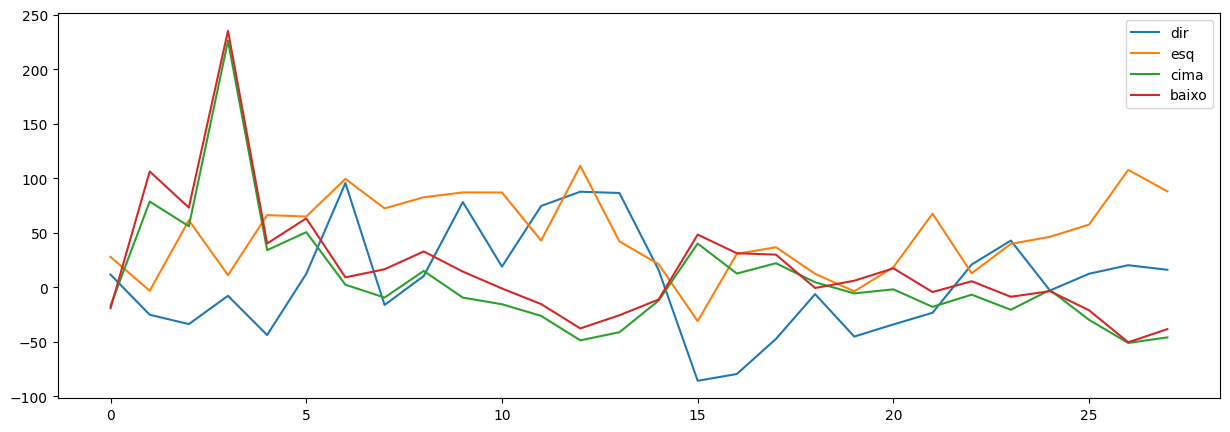

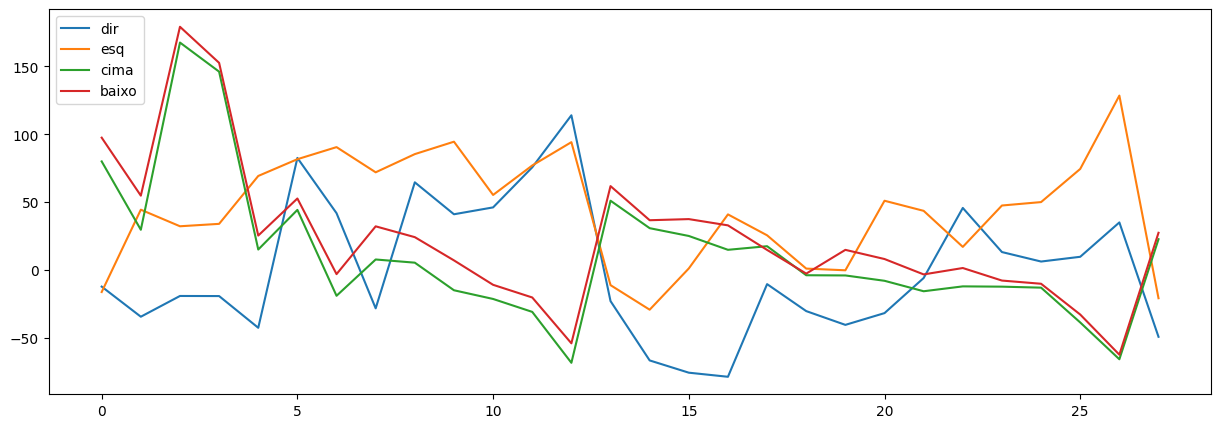

In [281]:
# Aplicação dos filtros
rcParams['figure.figsize'] = [15., 5.]
filtered_datas = []
for i in range(2):
    # print("Grafico do sujeito {i} antes do filtro")
    # print_graphs(data[i])
    # Função para aplicar os filtros de banda e notch
    def apply_filters(data, lowcut, highcut, notch_cutoff, notch_var=1, fs=200, order=4):
        # Aplicar o filtro de banda
        data = data.reshape(data.shape[1], data.shape[0], data.shape[2])
        data_bandpass = np.apply_along_axis(lambda x: butter_bandpass(x, lowcut, highcut, fs, order), axis=-2, arr=data)

        # Aplicar o filtro notch
        data_filtered = np.apply_along_axis(lambda x: butter_notch(x, notch_cutoff, notch_var, fs, order), axis=-2, arr=data_bandpass)

        return data_filtered

    # Parâmetros dos filtros
    lowcut = 0.5  # Freq. de corte inferior para o filtro de banda
    highcut = 50.0  # Freq. de corte superior para o filtro de banda
    notch_cutoff = 60.0  # Freq. central para o filtro notch
    
    # Aplicar os filtros aos dados
    filtered_datas.append(apply_filters(data[i], lowcut, highcut, notch_cutoff))

    # Verificar as dimensões dos dados filtrados
    print("Grafico do sujeito {i} depois do filtro")
    # print_graphs(filtered_data)

filtered_datas = np.array(filtered_datas)
filtered_datas = filtered_datas.reshape(filtered_datas.shape[0], filtered_datas.shape[2], filtered_datas.shape[1], filtered_datas.shape[3])
filtered_datas.shape

##graficos dos dados filtrados
for i in range(2):
    plt.plot(filtered_datas[i, :, 0, 0])
    plt.plot(filtered_datas[i, :, 0, 1])
    plt.legend(labels_str)
plt.show()

for i in range(2):
    plt.plot(filtered_datas[i, :, 1, 0])
    plt.plot(filtered_datas[i, :, 1, 1])
    plt.legend(labels_str)
plt.show()


# Segmentação

## Porque segmentar os dados em janelamento?
- Segmenta em mais informações para levar mais contextualização para o classificador

In [282]:
filtered_datas.shape
# data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], data.shape[3])
# print(data.shape)
data = filtered_datas.reshape(filtered_datas.shape[0],filtered_datas.shape[1], filtered_datas.shape[2], filtered_datas.shape[3])
print(data.shape)

# data = filtered_datas[:, :, :, 100:950] 
    ##Acuracia participante 1:  0.3333333333333333
    ##Acuracia participante 2:  0.25

# data = filtered_datas[:, :, :, 300:950] 
    ##Acuracia participante 1:  0.3333333333333333
    ##Acuracia participante 2:  0.25
# data = filtered_datas[:, :, :, 200:650]   
# Acuracia participante 1:  0.16666666666666666
# Acuracia participante 2:  0.25

# data = filtered_datas[:, :, :, :650]  
# Acuracia participante 1:  0.16666666666666666
# Acuracia participante 2:  0.25

##sem corte
# Acuracia participante 1:  0.16666666666666666
# Acuracia participante 2:  0.4166666666666667

(2, 28, 2, 1000)


In [283]:
# Aplicação da segmentação (dom, tempo e frequencia)
from scipy.signal import stft

step = 29 # Se mudar isso aq da problema(nao vai bater o numero de janelas)
segment = 64
nperseg_freq = 64
print("Shape inicial: ", data.shape)

overlap_time = 0  # Iniciando com sobreposição zero no domínio do tempo
overlap_freq = nperseg_freq // 2  # Sobreposição de 50% no domínio da frequência

n_win = int((data.shape[-1] - segment) / (overlap_time + 1)) + 1
ids = np.arange(n_win) * (overlap_time + 1)


# Janelas do dado no dominio do tempo
chunks_time = np.array([data[:,:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3, 4)

_, _, chunks_freq = signal.stft(data, fs=200, nperseg=segment, noverlap=32)
chunks_freq = np.swapaxes(chunks_freq, 2, 3)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)')

# Quer dizer que tem 33 janelas com 64 pontos
# 33 * 64 = 2112
    # Faz sentido, porque temos 1000 pontos, ai como dividimos em 33 janelas de 29 passos, ele tem mais que o dobro realmente

# O da frequencia saiu diferente
    # Nao importa a quantidade de pontos na ultima dimensao, o que tem que bater é quantidade de janelas
    


Shape inicial:  (2, 28, 2, 1000)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (2, 28, 937, 2, 64) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (2, 28, 33, 2, 33) - (classes+ensaios, canais, janelas, linhas)


*Tarefa 2*: Separar os participantes e armazenar os dados em disco para execução das próximas tarefas.

In [284]:
data.shape

part_data = []

for i in range(2):
    part_data.append(data[i*28:(i+1)*28])
    np.save(f"datasets/part_data{i}.npy", part_data[i])




    np.save(f"datasets/participant_{i}_time.npy", chunks_time[i])
    np.save(f"datasets/participant_{i}_freq.npy", chunks_freq[i])





### Shape dos dados salvos

In [285]:
time_freq_1 = np.load("datasets/participant_0_time.npy")
time_freq_2 = np.load("datasets/participant_1_time.npy")
time_freq_1.shape, time_freq_2.shape


((28, 937, 2, 64), (28, 937, 2, 64))

In [286]:
freq_freq_1 = np.load("datasets/participant_0_freq.npy")
freq_freq_2 = np.load("datasets/participant_1_freq.npy")

freq_freq_1.shape, freq_freq_2.shape

((28, 33, 2, 33), (28, 33, 2, 33))